# Notes: You will have to:
  >1- Make a Copy of this notebook to edit it for your solutions;
  >
  >2- Upload on Gradescope: The `Colab Notebook edited with your solutions`, and a `pdf Report (Discussion questions)`.

# Question 1: MLP Implementation with Numpy

In this exercise, we will explore the construction of a multi-layer perceptron (MLP) by coding it from the ground up. We will develop a deep neural network step-by-step, beginning with a single neuron, progressing to a layer, and ultimately building the entire network. We will then train this network and evaulate on an interesting dataset and try to understand the workings in more details.

## Installing dependencies

In [2]:
# !pip install numpy scikit-learn matplotlib

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles

## Q 1.1 (a): Activation Functions

In this question you will implement the softmax and ReLU activation functions and their derivatives. Both these functions help introduce non-linearity which gives neural network their capacity. We will implement these functions in the `ActivationFunction` class as static methods. You can access the method later using the following code:

```
# For softmax activation
ActivationFunction.softmax(x)

# For calucating the derivative of softmax function
ActivationFunction.softmax_derivative(x)

# For ReLU activation
ActivationFunction.relu(x)

# For calculating the derivative of ReLU function
ActivationFunction.relu_derivative(x)
```

In [4]:
class ActivationFunction:
    @staticmethod
    def softmax(x):
        """
        Compute the Softmax activation function.

        Args:
            x (np.array): Input values

        Returns:
            np.array: Softmax activation values
        """
        ### Write your code here ###
        if x.ndim == 0:
            return np.array(1.0, dtype=float)
        if x.ndim == 1:
            return np.exp(x) / (np.sum(np.exp(x)))
        else:
            return np.exp(x) / np.sum(np.exp(x), axis=-1, keepdims=True)
        

    @staticmethod
    def softmax_derivative(x):
        """
        Compute the derivative of the Softmax function.

        Args:
            x (np.array): Input values

        Returns:
            np.array: Derivative of Softmax function
        """
        ### Write your code here ###

        exps = np.exp(x - np.max(x))  
        s = exps / np.sum(exps)

        return  np.diag(s) - np.outer(s, s)

    @staticmethod
    def relu(x):
        """
        Compute the ReLU activation function.

        Args:
            x (np.array): Input values

        Returns:
            np.array: ReLU activation values
        """
        ### Write your code here ###
        return np.maximum(0, x)

    @staticmethod
    def relu_derivative(x):
        """
        Compute the derivative of the ReLU activation function.

        Args:
            x (np.array): Input values

        Returns:
            np.array: Derivative of ReLU function
        """
        ### Write your code here ###
        return np.where(x > 0, 1, 0)

## Q 1.1 (b): Neuron Implementation

Neuron is the fundamental building block of MLP. A neuron simulates a biological neuron which can be activated or fired when responding to a stimulus. The equation of a neuron is as follow:

$$ f(x) = a(\mathbf{w} \cdot \mathbf{x} + b) $$

where inputs $\mathbf{x}$ and weights $\mathbf{w}$ are multidimensional vectors, bias $b$ is a scalar, $a(.)$ is an activation function.

**Note:** For the whole exercise you will be receiving inputs of batch size of 1.

In [5]:
class Neuron:
    def __init__(self, input_size, activation_function):
        """
        Initialize a neuron with random weights and bias.

        Args:
            input_size (int): Number of input features
            activation_function (function): Activation function to use
        """
        ### Write your code here ###
        self.activation_function = activation_function
        self.weights = np.random.randn(input_size)
        self.bias = np.random.randn()

    def activate(self, x):
        """
        Compute the activation of the neuron.

        Args:
            x (np.array): Input features

        Returns:
            float: Activation value
        """
        ### Write your code here ###
        return self.activation_function(self.weights @ x + self.bias)

## Q 1.1(c): Layer Implementation

Now we will compose a layer which consists of multiple neurons. Complete initializing the layer and compute the forward pass by sending the input through each neuron of the layer.

In [6]:
class Layer:
    def __init__(self, input_size, output_size, activation_function):
        """
        Initialize a layer of neurons.

        Args:
            input_size (int): Number of input features
            output_size (int): Number of neurons in the layer
            activation_function (function): Activation function to use
        """
        ## Write your code here ##
        self.neurons = [Neuron(input_size, activation_function) for _ in range(output_size)]
    

    def forward(self, x):
        """
        Compute the forward pass through the layer.

        Args:
            x (np.array): Input features

        Returns:
            np.array: Output of the layer
        """
        ### Write your code here ###
        return np.array([neuron.activate(x) for neuron in self.neurons])

## Q 1.1(d) + 2 (a) to (d): Neural Network Construction

Now we have built all the building blocks required to build our neural network. Complete the implementations using the hints given in the code. There are additional functions that will be useful later. Do not modify these.

In [7]:
import numpy as np

class NeuralNetwork:
    def __init__(self, layer_sizes, hidden_dim, activation_function_hidden, activation_output):
        """
        Initialize a neural network with specified layer sizes.

        Args:
            layer_sizes (list): List of integers representing the size of each layer
            hidden_dim (int): Dimension of hidden layers
            activation_function_hidden (function): Activation function for hidden layers
            activation_output (function): Activation function for output layer
        """
        self.layers = []
        self.hidden_dim = hidden_dim
        self.activation_function_hidden = activation_function_hidden
        self.activation_output = activation_output
        
        # Build layers according to layer_sizes
        for i in range(len(layer_sizes) - 1):
            input_size = layer_sizes[i]
            output_size = layer_sizes[i + 1]
            if i < len(layer_sizes) - 2:
                activation = activation_function_hidden
            else:
                 activation = lambda x: x 
            self.layers.append(Layer(input_size, output_size, activation))


    def forward(self, x):
        """
        Compute forward pass through network.

        Args:
            x (np.array): Input features

        Returns:
            np.array: Output probabilities after softmax
        """
        output = x
        self.activations = [x]
        self.pre_activations = []

        for layer in self.layers:
            output = layer.forward(output)
            self.activations.append(output)

        z = output  
        self.pre_activations.append(z)

        exp_logits = np.exp(z - np.max(z))
        softmax_output = exp_logits / np.sum(exp_logits)
        self.activations[-1] = softmax_output

        return softmax_output

    def layer_backward(self, delta, layer_index, activations, zs):
        """
        Backpropagation for a single layer.

        Args:
            delta (np.array): gradient of loss wrt current layer output (shape: layer_size)
            layer_index (int): index of current layer
            activations (list): list of activations from forward pass
            zs (list): list of pre-activation (z) values from forward pass

        Returns:
            tuple: (delta for previous layer, gradient_w, gradient_b)
        """
        layer = self.layers[layer_index]
        z = zs[layer_index]
        a_prev = activations[layer_index]  # activation of previous layer

        if layer_index == len(self.layers) - 1:
            # output layer with softmax + cross-entropy: delta is already (output - target)
            pass
        else:
            # hidden layers with ReLU activation
            if self.activation_function_hidden == ActivationFunction.relu:
                delta = delta * ActivationFunction.relu_derivative(z)
            else:
                raise ValueError("Unsupported activation function")

        gradient_w = np.outer(delta, a_prev)  # shape: (current_layer_size, previous_layer_size)
        gradient_b = delta  # shape: (current_layer_size,)

        weights = np.array([neuron.weights for neuron in layer.neurons])  # shape: (current_layer_size, previous_layer_size)
        delta_prev = np.dot(weights.T, delta)  # backpropagate delta to previous layer

        return delta_prev, gradient_w, gradient_b


    def backward(self, x, y, learning_rate):
        """
        Perform backpropagation and update weights.

        Args:
            x (np.array): input features
            y (np.array): true one-hot labels
            learning_rate (float): learning rate
        """
        activations = [x]
        zs = []
        for layer in self.layers:
            z = np.array([np.dot(neuron.weights, activations[-1]) + neuron.bias for neuron in layer.neurons])
            zs.append(z)
            activation = layer.forward(activations[-1])
            activations.append(activation)

        # delta at output layer: output - target (for softmax + cross-entropy)
        delta = activations[-1] - y

        for i in reversed(range(len(self.layers))):
            delta, gradient_w, gradient_b = self.layer_backward(delta, i, activations, zs)

            for j, neuron in enumerate(self.layers[i].neurons):
                neuron.weights -= learning_rate * gradient_w[j]
                neuron.bias -= learning_rate * gradient_b[j]


    def train(self, X, y, epochs, learning_rate):
        """
        Train the neural network.

        Args:
            X (np.array): training features (num_samples, input_size)
            y (np.array): one-hot encoded labels (num_samples, num_classes)
            epochs (int): number of training epochs
            learning_rate (float): learning rate
        """
        train_losses = []

        for epoch in range(epochs):
            predictions = []

            for i in range(len(X)):
                x_sample = X[i]
                y_sample = y[i]

                prediction = self.forward(x_sample)
                predictions.append(prediction)

                self.backward(x_sample, y_sample, learning_rate)

            predictions = np.array(predictions)
            avg_loss = self.compute_loss(predictions, y)
            train_losses.append(avg_loss)

            
            print(f"Epoch {epoch}, Loss: {avg_loss:.4f}")

        return train_losses


    def compute_loss(self, predictions, targets):
        """
        Compute average cross-entropy loss.

        Args:
            predictions (np.array): predicted softmax probabilities (batch_size, num_classes)
            targets (np.array): one-hot encoded true labels (batch_size, num_classes)

        Returns:
            float: average cross-entropy loss
        """
        epsilon = 1e-9
        predictions = np.clip(predictions, epsilon, 1 - epsilon)
        loss = -np.sum(targets * np.log(predictions)) / predictions.shape[0]
        return loss


    def predict(self, X):
        """
        Make predictions for a batch of inputs.

        Args:
            X (np.array): input features (num_samples, input_size)

        Returns:
            np.array: predictions (num_samples, num_classes)
        """
        return np.array([self.forward(x) for x in X])

# Q 1.2(d): Training and Visualizing Neural Network

In the rest of the exercise we will use the components we built earlier to train a neural network and visualise the loss curve. To make things simple we will be building neural networks with only one hidden layer.

We will use the MNIST dataset for all our experiements which consists of 10 classes.


In [ ]:
# # Uncomment the below code to create the dataset. And comment it when submitting to gradescope

# np.random.seed(42) # Do not change
# # For easy data loading and processing, we're using torch here. You're not allowed to use torch for Neural Net components though.
# def get_train_test_dataset():
#     import torch
#     from torchvision import datasets, transforms
#     from sklearn.model_selection import train_test_split

#     # Define a transform to convert images to tensors and normalize
#     transform = transforms.Compose([
#         transforms.ToTensor()
#     ])

#     # Load the MNIST dataset
#     mnist_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)

#     # Take a subset of 1000 samples
#     X = mnist_dataset.data[:1000].float() / 255.0  # Normalize pixel values to [0,1]
#     y = mnist_dataset.targets[:1000]

#     # Convert X to numpy arrays and flatten images from 28x28 to 784 features
#     X = X.numpy().reshape(-1, 28*28)
#     y = y.numpy()

#     # Split dataset into training and test sets (e.g., 80% train, 20% test)
#     X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

#     print("Training set shape:", X_train.shape, y_train.shape)
#     print("Test set shape :", X_test.shape, y_test.shape)

#     return X_train, y_train, X_test, y_test


## Let's visualize a few samples

Training set shape: (800, 784) (800,)
Test set shape : (200, 784) (200,)


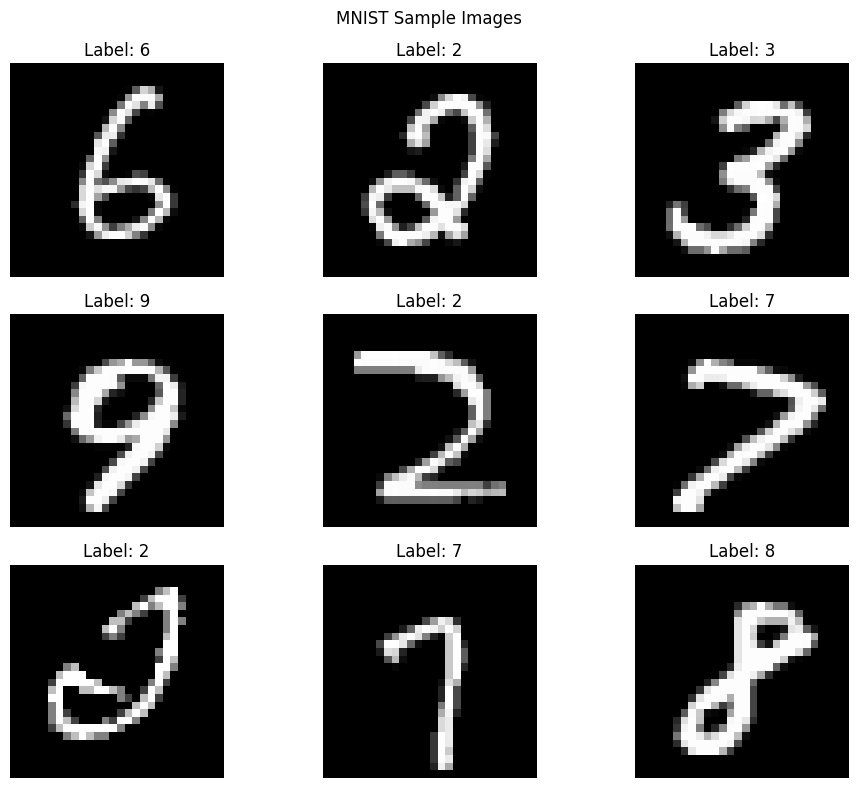

In [9]:
# Plot a few images

def visualize_mnist_samples(X, y, num_samples=9):
    """Visualize MNIST sample images"""
    plt.figure(figsize=(10, 8))
    for i in range(min(num_samples, len(X))):
        plt.subplot(3, 3, i + 1)
        # Reshape from flattened to 28x28 for visualization
        img = X[i].reshape(28, 28)
        plt.imshow(img, cmap='gray')
        plt.title(f"Label: {y[i]}")
        plt.axis('off')

    plt.suptitle('MNIST Sample Images')
    plt.tight_layout()
    plt.show()
X_train, y_train, X_test, y_test =  get_train_test_dataset()
visualize_mnist_samples(X_train, y_train)

Below you have been given the code to train your neural network. and visualize the decision boundry. Modify the hyperparameters to train and visualize the neural network and report your findings in the practical report. We will be testing our model on the training set. The `plot_decision_boundary` method takes the data created earlier and the neural network you trained to show the decision boundry.

In [10]:
def train_network(hidden_layer_size=1, hidden_dim=64,
                  epochs=10, activation_hidden=np.tanh,
                  activation_output=None, learning_rate=0.001):
    """
    Trains a neural network on MNIST and evaluates performance.

    Parameters:
        X_train, y_train: Training data (images and labels)
        X_test, y_test: Test data (for evaluation)
        hidden_layer_size: Number of hidden layers
        hidden_dim: Number of neurons per hidden layer
        epochs: Training epochs
        activation_hidden: Activation function for hidden layers
        activation_output: Activation for output (e.g., softmax)
        learning_rate: Learning rate

    Returns:
        nn: Trained neural network object
        train_loss: Training loss history
        train_accuracy: Accuracy on training set
        test_accuracy: Accuracy on test set
    """
    X_train, y_train, X_test, y_test = get_train_test_dataset()
    input_size, output_size = 28 * 28, 10
    layers = [input_size] + [hidden_dim] * hidden_layer_size + [output_size]

    # Initialize network
    nn = NeuralNetwork(layers, hidden_dim, activation_hidden, activation_output)


    # --- Prepare training data ---
    X_train_flat = X_train.reshape(X_train.shape[0], -1) / 255.0  # Normalize
    y_train_np = y_train.numpy() if hasattr(y_train, "numpy") else y_train
    y_train_onehot = np.eye(output_size)[y_train_np]  # One-hot encode

    # --- Train the model ---
    train_loss = nn.train(X_train_flat, y_train_onehot,
                          epochs=epochs, learning_rate=learning_rate)

    # --- Evaluate on training data ---
    preds_train = np.array([nn.forward(x) for x in X_train_flat])

    preds_train_labels = np.argmax(preds_train, axis=1)
    train_accuracy = np.mean(preds_train_labels == y_train_np)

    # --- Evaluate on test data ---
    X_test_flat = X_test.reshape(X_test.shape[0], -1) / 255.0
    y_test_np = y_test.numpy() if hasattr(y_test, "numpy") else y_test
    preds_test = np.array([nn.forward(x) for x in X_test_flat])
    preds_test_labels = np.argmax(preds_test, axis=1)
    test_accuracy = np.mean(preds_test_labels == y_test_np)

    return nn, train_loss, train_accuracy, test_accuracy, X_test, y_test


In [ ]:
# # Write the code to train and visualize
# # Consider commenting this out when submitting to gradescope

# # --- Set Hyperparameters ---
# hidden_layer_size = 2            # Number of hidden layers
# hidden_dim = 64                  # Neurons per hidden layer
# epochs = 20                      # Training epochs
# activation_hidden = ActivationFunction.relu     # Hidden layer activation
# activation_output = ActivationFunction.softmax         # Let the loss function handle softmax internally
# learning_rate = 0.001             # Learning rate

# # --- Train the network ---
# nn, train_loss, train_accuracy, test_accuracy,  X_test, y_test = train_network(
#     hidden_layer_size=hidden_layer_size,
#     hidden_dim=hidden_dim,
#     epochs=epochs,
#     activation_hidden=activation_hidden,
#     activation_output=activation_output,
#     learning_rate=learning_rate
# )

# print(f"Train Accuracy: {train_accuracy * 100:.2f}%")
# print(f"Test Accuracy:  {test_accuracy * 100:.2f}%")


Training set shape: (800, 784) (800,)
Test set shape : (200, 784) (200,)
Epoch 0, Loss: 2.5594
Epoch 1, Loss: 2.4529
Epoch 2, Loss: 2.4208
Epoch 3, Loss: 2.3901
Epoch 4, Loss: 2.3635
Epoch 5, Loss: 2.3453
Epoch 6, Loss: 2.3305
Epoch 7, Loss: 2.3185
Epoch 8, Loss: 2.3073
Epoch 9, Loss: 2.2970
Epoch 10, Loss: 2.2882
Epoch 11, Loss: 2.2800
Epoch 12, Loss: 2.2722
Epoch 13, Loss: 2.2656
Epoch 14, Loss: 2.2593
Epoch 15, Loss: 2.2534
Epoch 16, Loss: 2.2479
Epoch 17, Loss: 2.2428
Epoch 18, Loss: 2.2378
Epoch 19, Loss: 2.2327
Train Accuracy: 20.75%
Test Accuracy:  21.50%


# Q 1.3: Reporting and analysis
Analyze your trained model and present findings clearly as asked in the instruction PDF.

In [20]:
print("Train accuracy: ", train_accuracy)
print("Test accuracy: ", test_accuracy)
# plt.plot(range(1, epochs + 1), train_loss, marker='o')
# plt.xlabel('Epoch')
# plt.ylabel('Training Loss')
# plt.title('Training Loss per Epoch')
# plt.grid(True)
# plt.show()


Train accuracy:  0.2075
Test accuracy:  0.215


# Training loss curve

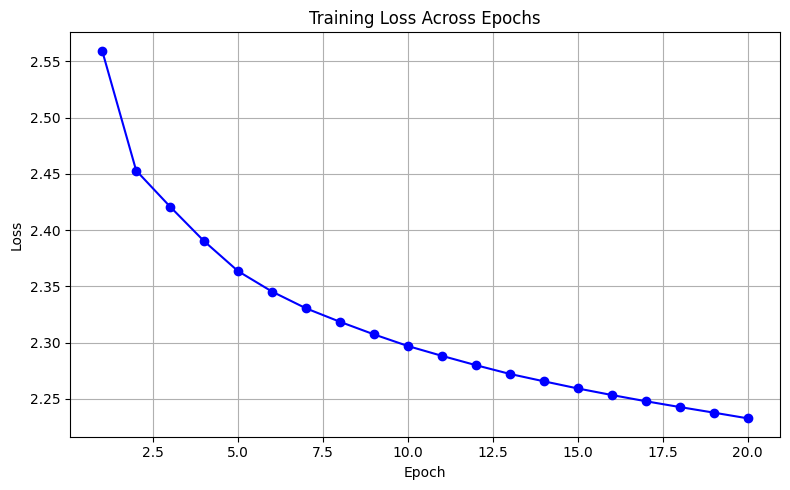

In [21]:
# Plot the training loss across 20 epochs

def plot_loss_curve(train_loss):
  # Write your code here
  epochs = range(1, len(train_loss) + 1)
  plt.figure(figsize=(8, 5))
  plt.plot(epochs, train_loss, marker='o', linestyle='-', color='b')
  plt.title("Training Loss Across Epochs")
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.grid(True)
  plt.tight_layout()
  plt.show()
plot_loss_curve(train_loss)

## Layer activation visualization

PCA Visualization


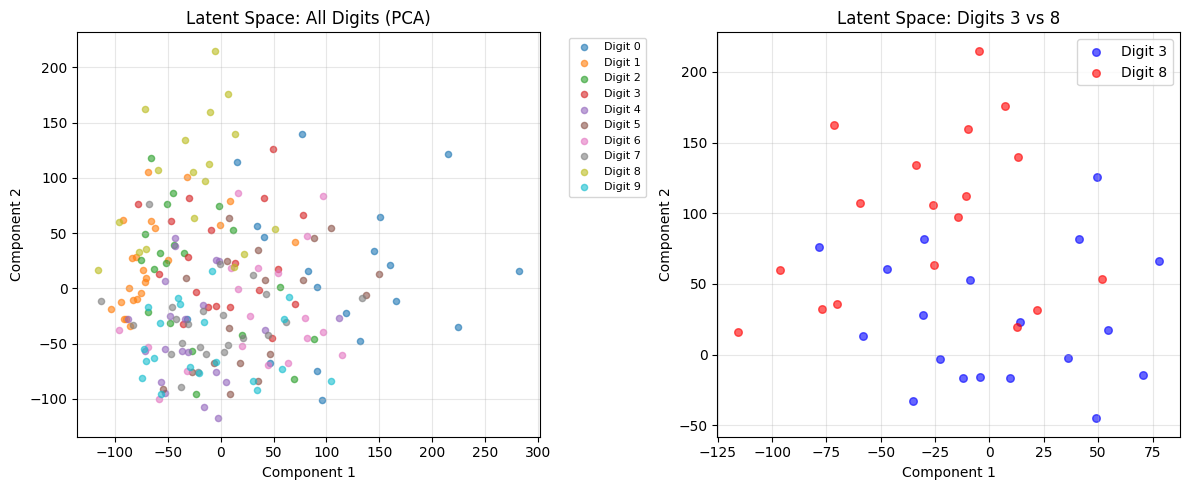


Explained variance ratio: [0.17813776 0.14796636]
Total variance explained: 32.61%
Number of samples - Digit 3: 19, Digit 8: 18

t-SNE Visualization


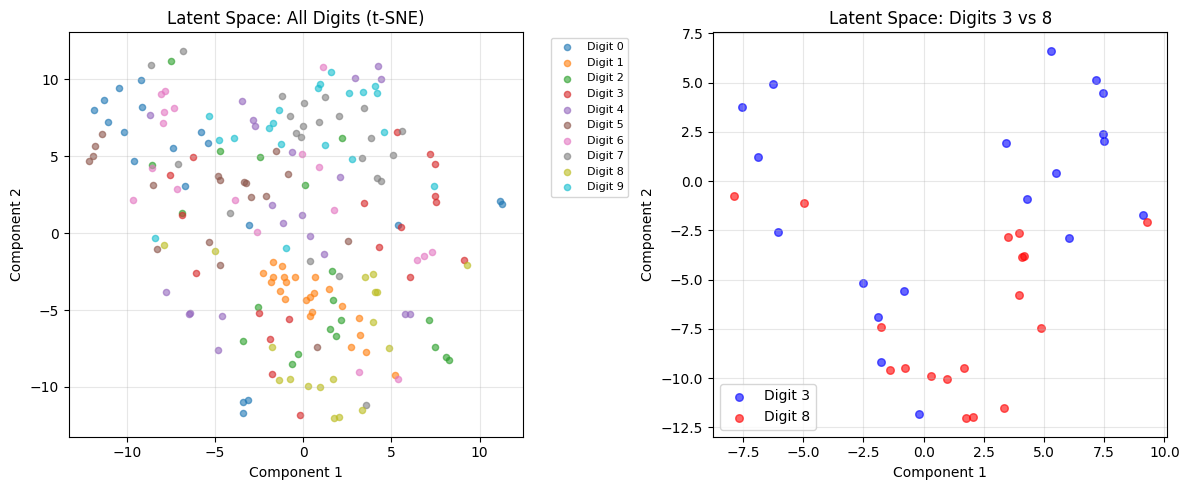

Number of samples - Digit 3: 19, Digit 8: 18


In [22]:
# ===== Latent Space Visualization =====
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import numpy as np
import matplotlib.pyplot as plt

def get_penultimate_activations(nn, X_batch):
    """Get activations from the last hidden layer"""
    activations_list = []
    for x in X_batch:
        activations = x
        for layer in nn.layers[:-1]:
            activations = layer.forward(activations)
        activations_list.append(activations)
    return np.array(activations_list)

def visualize_activations(nn, X_test, y_test, digits=(3, 8), method='PCA'):
    """Visualize layer activations using PCA or t-SNE"""
    Z = get_penultimate_activations(nn, X_test)
    
    if method == 'PCA':
        reducer = PCA(n_components=2)
    else: 
        reducer = TSNE(n_components=2, random_state=42)
    
    Z_2d = reducer.fit_transform(Z)
    
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    for digit in range(10):
        mask = y_test == digit
        plt.scatter(Z_2d[mask, 0], Z_2d[mask, 1], 
                   label=f'Digit {digit}', alpha=0.6, s=20)
    plt.title(f'Latent Space: All Digits ({method})')
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
    plt.grid(True, alpha=0.3)
    
    plt.subplot(1, 2, 2)
    mask1 = y_test == digits[0]
    mask2 = y_test == digits[1]
    
    plt.scatter(Z_2d[mask1, 0], Z_2d[mask1, 1], 
               c='blue', label=f'Digit {digits[0]}', alpha=0.6, s=30)
    plt.scatter(Z_2d[mask2, 0], Z_2d[mask2, 1], 
               c='red', label=f'Digit {digits[1]}', alpha=0.6, s=30)
    
    plt.title(f'Latent Space: Digits {digits[0]} vs {digits[1]}')
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    plt.legend(fontsize=10)
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    if method == 'PCA':
        print(f"\nExplained variance ratio: {reducer.explained_variance_ratio_}")
        print(f"Total variance explained: {sum(reducer.explained_variance_ratio_):.2%}")
    
    print(f"Number of samples - Digit {digits[0]}: {mask1.sum()}, Digit {digits[1]}: {mask2.sum()}")
    
    return Z_2d

print("=" * 50)
print("PCA Visualization")
print("=" * 50)
Z_pca = visualize_activations(nn, X_test, y_test, digits=(3, 8), method='PCA')

print("\n" + "=" * 50)
print("t-SNE Visualization")
print("=" * 50)
Z_tsne = visualize_activations(nn, X_test, y_test, digits=(3, 8), method='t-SNE')

## Hyperparemeter discussion
You can try out changing hypermaters (leraning rate, hidden dim, num. of hidden layers) and report how that impact training loss, train/test accuracy

## Question 2: Convolutional Neural Network (using PyTorch)

### Setup

In [25]:

import math, random, time
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

SEED = 42
random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# Hyperparameters
learning_rate = 1e-3  # or 3e-4
num_epochs = 20
batch_size = 64
num_classes = 10
validation_split = 0.2


Device: cuda



## Part 1: Implementing the CNN

You will build the core components of the CNN, with **both** forward and backward passes.

### (a) Fully Connected Layer
Implement a linear layer:
y = xW^T + b

In [26]:

class CustomLinear(nn.Module):
    def __init__(self, in_features, out_features, bias=True):
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.weight = nn.Parameter(torch.Tensor(out_features, in_features))
        self.bias   = nn.Parameter(torch.Tensor(out_features)) if bias else None
        self.reset_parameters()
        self._cache_x = None

    def reset_parameters(self):
        # Kaiming Uniform (fixed by assignment)
        nn.init.kaiming_uniform_(self.weight, a=math.sqrt(5))
        if self.bias is not None:
            fan_in, _ = nn.init._calculate_fan_in_and_fan_out(self.weight)
            bound = 1 / math.sqrt(fan_in)
            nn.init.uniform_(self.bias, -bound, bound)

    def forward(self, x):
        """
        TODO: Compute y = x W^T + b.
        Hints:
          • Use a batched matmul pattern that preserves leading batch dims.
          • Add bias if present.
        """
        self._cache_x = x
        "WRITE YOUR CODE HERE"
        output = x @ self.weight.T  # Matrix multiply
        if self.bias is not None:
            output += self.bias  # Add bias (broadcasted over batch)
        return output

    def backward(self, grad_output):
        """
        TODO: Compute gradients wrt input, weight, bias.
        param grad_output: gradient wrt output
        Return: (grad_input, grad_weight, grad_bias)
        """
        x = self._cache_x
        "WRITE YOUR CODE HERE"
        grad_input = grad_output @ self.weight 

        # Gradient w.r.t weights: dL/dW = grad_output^T @ x
        grad_weight = grad_output.T @ x

        grad_bias = grad_output.sum(dim=0) if self.bias is not None else None

        return grad_input, grad_weight, grad_bias


### (b) Convolution Layer
Implement a 2D convolution layer with basic operations

In [27]:

class CustomConv2D(nn.Module):
    """
    2D Convolution (k x k) with manual forward/backward using unfold/fold.

    Shapes and symbols:
      x: input of shape (N, C_in, H, W)
        N = batch size, C_in = input channels, H/W = spatial dims: Heigth/Width
      w: weights of shape (C_out, C_in, k, k), with C_out = output channels
      b: bias of shape (C_out,)
      k: kernel_size
      s: stride
      p: padding

      H_out = floor((H + 2*p - k)/s) + 1
      W_out = floor((W + 2*p - k)/s) + 1
      L = H_out * W_out   # number of sliding-window locations per feature map
    """
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0):
        super().__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding
        self.weight = nn.Parameter(torch.Tensor(out_channels, in_channels, kernel_size, kernel_size))
        self.bias   = nn.Parameter(torch.Tensor(out_channels))
        self.reset_parameters()
        self._cache_x = None

    def reset_parameters(self):
        # Kaiming Uniform (fixed)
        nn.init.kaiming_uniform_(self.weight, a=math.sqrt(5))
        fan_in, _ = nn.init._calculate_fan_in_and_fan_out(self.weight)
        bound = 1 / math.sqrt(fan_in)
        nn.init.uniform_(self.bias, -bound, bound)

    def forward(self, x):
        """
        TODO: Compute conv output using F.unfold and a batched dot-product.
        Hints:
          • Unfold to shape (N, C_in*k*k, L) where L is number of locations.
          • Reshape weights to (C_out, C_in*k*k).
          • Add bias per output channel.
          • Reshape to (N, C_out, H_out, W_out).
        """
        self._cache_x = x
        "WRITE YOUR CODE HERE"
        N, C_in, H, W = x.shape
        k = self.kernel_size
        s = self.stride
        p = self.padding

        x_unfold = F.unfold(x, kernel_size=k, stride=s, padding=p)
        self._cache_x = x
        self._cache_x_unfold = x_unfold

        weight_flat = self.weight.view(self.out_channels, -1)  # (C_out, C_in * k * k)

        # Correct matmul: (N, L, C_in*k*k) @ (C_in*k*k, C_out).T = (N, L, C_out)
        out = x_unfold.transpose(1, 2) @ weight_flat.T
        out = out.transpose(1, 2)  # (N, C_out, L)

        out += self.bias.view(1, -1, 1)  # (1, C_out, 1)


        H_out = (H + 2 * p - k) // s + 1
        W_out = (W + 2 * p - k) // s + 1
        self._output_shape = (H_out, W_out)

        # Reshape to (N, C_out, H_out, W_out)
        return out.view(N, self.out_channels, H_out, W_out)

    def backward(self, grad_output):
        """
        TODO: Compute gradients wrt input, weight, bias.
        Hints:
          • Reuse unfolded patches.
          • grad_weight: correlate grad_output with unfolded input patches.
          • grad_bias: sum grad_output over batch and spatial locations.
          • grad_input: map grads back via an unfolded representation and fold.
        Return: (grad_input, grad_weight, grad_bias)
        """
        x = self._cache_x
        "WRITE YOUR CODE HERE"
        x_unfold = self._cache_x_unfold  # (N, in_channels * k^2, L)
        H_out, W_out = self._output_shape
        N = grad_output.shape[0]

        grad_output_flat = grad_output.view(N, self.out_channels, -1)  # (N, out_channels, L)
        weight_flat = self.weight.view(self.out_channels, -1)  # (out_channels, in_channels * k^2)

        # grad_weight: correlate grad_output with input patches
        # grad_output_flat: (N, out_channels, L)
        # x_unfold: (N, in_channels*k^2, L)
        grad_weight = torch.bmm(grad_output_flat, x_unfold.permute(0, 2, 1))  # (N, out_channels, in_channels*k^2)
        grad_weight = grad_weight.sum(dim=0)  # sum over batch, shape (out_channels, in_channels*k^2)
        grad_weight = grad_weight.view_as(self.weight)  # reshape to weight shape

        # grad_bias: sum over batch and spatial locations
        grad_bias = grad_output_flat.sum(dim=(0, 2)) if self.bias is not None else None  # shape (out_channels,)

        # grad_input (already computed)
        grad_input_unfold = torch.bmm(weight_flat.t().unsqueeze(0).expand(N, -1, -1), grad_output_flat)  # (N, in_channels*k^2, L)


        grad_input = F.fold(
            grad_input_unfold,
            output_size=x.shape[2:],  # original H, W of input
            kernel_size=self.kernel_size,
            stride=self.stride,
            padding=self.padding
        )

        return grad_input, grad_weight, grad_bias

### (c) Max Pooling Layer
Implement a max pooling layer

In [28]:

class CustomMaxPool2D(nn.Module):
    """
    Max Pooling (k x k) with manual forward/backward using unfold/fold.

    Shapes and symbols:
      x: input of shape (N, C, H, W)
        N = batch size, C = channels, H/W = spatial dims: Height, Width
      k: kernel_size (pool window is k x k)
      s: stride
      p: padding

      H_out = floor((H + 2*p - k)/s) + 1
      W_out = floor((W + 2*p - k)/s) + 1
      L = H_out * W_out   # number of sliding-window locations per feature map
    """
    def __init__(self, kernel_size, stride=None, padding=0):
        super().__init__()
        self.kernel_size = kernel_size
        self.stride = stride if stride is not None else kernel_size
        self.padding = padding
        self._cache_shape = None
        self._cache_indices = None

    def forward(self, x):
        """
        TODO: Max over k*k windows.
        Hints:
          • Unfold x → patches of shape (N, C*k*k, L)
          • View → (N, C, k*k, L)
          • Take max over the k*k dimension → outputs (N, C, L) and argmax indices (N, C, L)
          • Cache argmax indices + shapes.
          • Reshape output reshaped to (N, C, H_out, W_out).
        """
        "WRITE YOUR CODE HERE"
        N, C, H, W = x.shape
        k = self.kernel_size
        s = self.stride
        p = self.padding

        self._cache_shape = x.shape
        x_padded = F.pad(x, (p, p, p, p))
        x_unfolded = F.unfold(x_padded, kernel_size=k, stride=s)
        x_unfolded = x_unfolded.view(N, C, k * k, -1)
        out, indices = x_unfolded.max(dim=2)  # (N, C, L)

        self._cache_indices = indices

        # Compute H_out and W_out
        H_out = (H + 2 * p - k) // s + 1
        W_out = (W + 2 * p - k) // s + 1

        # Reshape output to (N, C, H_out, W_out)
        return out.view(N, C, H_out, W_out)

    def backward(self, grad_output):
        """
        TODO: Implement max pooling backward (route grads to maxima only).
        Inputs: grad_output: (N, C, H_out, W_out)
        Hints:
          • Make zeros tensor grad_unfold of shape (N, C, k*k, L)
          • Scatter grad_output into grad_unfold at the argmax positions from forward
          • View grad_unfold → (N, C*k*k, L)
          • Fold back to image space → grad_input of shape (N, C, H, W)

        Return: grad_input(N, C, H, W)
        """
        "WRITE YOUR CODE HERE"
        N, C, H_out, W_out = grad_output.shape
        k = self.kernel_size
        s = self.stride
        p = self.padding
        H, W = self._cache_shape[2:]

        grad_output_flat = grad_output.view(N, C, -1)
        L = grad_output_flat.shape[-1]

        grad_unfold = torch.zeros(N, C, k * k, L, device=grad_output.device)
        grad_unfold.scatter_(2, self._cache_indices.unsqueeze(2), grad_output_flat.unsqueeze(2))
        grad_unfold = grad_unfold.view(N, C * k * k, L)

        grad_input_padded = F.fold(grad_unfold, 
                                   output_size=(H + 2 * p, W + 2 * p),
                                   kernel_size=k,
                                   stride=s)

        # Remove padding
        if p > 0:
            grad_input = grad_input_padded[:, :, p:-p, p:-p]
        else:
            grad_input = grad_input_padded

        return grad_input


### (d) Cross-Entropy Loss [2 points]
Implement cross-entropy loss with numerical stability

In [29]:

class CustomCrossEntropyLoss(nn.Module):
    def __init__(self, reduction="mean"):
        super().__init__()
        self.reduction = reduction
        self._cache = None

    def forward(self, logits, targets):
        """
        TODO: Compute numerically-stable cross-entropy.
        Hints:
          • Subtract max per row before exponentiation.
          • Convert to probabilities; pick class probs at targets.
          • Apply -log(...) and reduction (mean by default).
          • Cache what's needed for backward.
        """
        "WRITE YOUR CODE HERE"
        shifted_logits = logits - logits.max(dim=1, keepdim=True)[0] 

        log_probs = shifted_logits - torch.log(torch.sum(torch.exp(shifted_logits), dim=1, keepdim=True)) 
        N = logits.size(0)
        target_log_probs = log_probs[torch.arange(N), targets]


        loss = -target_log_probs  

        if self.reduction == "mean":
            loss = loss.mean()
        if self._cache is None:
          self._cache = {}
        # Cache for backward
        self._cache["logits"] = logits
        self._cache["targets"] = targets

        return loss

    def backward(self, logits=None, targets=None):
        """
        TODO: Compute gradient w.r.t. logits.
        Hints:
          • If `logits` and `targets` are provided, recompute softmax probs stably.
            Otherwise, use cached probs/targets from forward().
          • Divide by batch size if reduction == 'mean'.
        Return: grad_logits
        """
        "WRITE YOUR CODE HERE"
        if logits is None or targets is None:
            logits = self._cache["logits"]
            targets = self._cache["targets"]

        N, C = logits.shape

        # Numerical stability
        shifted_logits = logits - logits.max(dim=1, keepdim=True)[0]
        exp_logits = torch.exp(shifted_logits)
        softmax = exp_logits / exp_logits.sum(dim=1, keepdim=True) 


        grad_logits = softmax.clone()
        grad_logits[torch.arange(N), targets] -= 1  # subtract 1 at target class

        if self.reduction == "mean":
            grad_logits /= N

        return grad_logits




## Part 2: Training the CNN

Build and train the CNN for MNIST using **your custom layers**.

### (a) Training pipeline code
Address `TODO` in:
1. **Backward pass section** — explicit chaining with your `backward()` methods.  
2. **Parameter updates section** — manual updates using SGD-style with `torch.no_grad()`.

### (b) Training and experiments
Train your CNN on MNIST and run the following configurations:
1. **Activations (2):** ReLU, Tanh.  
2. **Learning rates (2):** 1e-3, 3e-4.

Use consistent hyperparameters across runs. This yields 4 configurations.


In [30]:
def get_activation(name):
    if name.lower() == "relu":
        return F.relu, lambda z: (z > 0).to(z.dtype)
    elif name.lower() == "tanh":
        return torch.tanh, lambda z: 1 - torch.tanh(z)**2
    else:
        raise ValueError("Unknown activation: " + name)

class CNN(nn.Module):
    def __init__(self, activation_name="relu", num_classes=10):
        super().__init__()
        self.ACT, self.ACT_PRIME = get_activation(activation_name)

        self.conv1 = CustomConv2D(1, 32, 5)
        self.conv2 = CustomConv2D(32, 64, 5)
        self.max1  = CustomMaxPool2D(2, stride=2)
        self.max2  = CustomMaxPool2D(2, stride=2)
        self.fc1   = CustomLinear(64*4*4, 512)
        self.fc2   = CustomLinear(512, num_classes)

        self.criterion = CustomCrossEntropyLoss()

    def forward(self, x):
        z1 = self.conv1(x)
        a1 = self.ACT(z1)
        p1 = self.max1(a1)
        d1 = p1.clone()

        z2 = self.conv2(p1)
        a2 = self.ACT(z2)
        p2 = self.max2(a2)
        d2 = p2.clone() 

        flat = torch.flatten(p2, start_dim=1)
        z3 = self.fc1(flat)
        a3 = self.ACT(z3)
        logits = self.fc2(a3)
        caches = (z1, a1, p1, d1, z2, a2, p2, d2, z3, a3)

        return logits, caches


### Data (MNIST)

In [31]:

full_train = datasets.MNIST(root="./data_CNN", train=True, download=True, transform=ToTensor())
test_ds    = datasets.MNIST(root="./data_CNN", train=False, download=True, transform=ToTensor())

train_size = int((1 - validation_split) * len(full_train))
val_size   = len(full_train) - train_size
train_ds, val_ds = random_split(full_train, [train_size, val_size])

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_ds, batch_size=batch_size, shuffle=False)

print(f"Train/Val/Test sizes: {len(train_ds)}/{len(val_ds)}/{len(test_ds)}")



Train/Val/Test sizes: 48000/12000/10000


### Utilities

In [32]:

@torch.no_grad()
def accuracy_from_logits(logits, labels):
    return (logits.argmax(dim=1) == labels).float().mean().item()

def sgd_update_(param, grad, lr):
    param -= lr * grad
    return param



### Training Pipeline code
Address the TODOs in the code below
> - Complete the BACKWARD PASS (explicit chaining with your `.backward` methods).
> - Uncomment the PARAMETER UPDATES (manual SGD with no_grad)


In [33]:

def train_one_config(activation_name="relu", epochs=num_epochs, lr=learning_rate, num_classes=num_classes):
    model = CNN(activation_name=activation_name, num_classes=num_classes).to(device)
    criterion = model.criterion

    train_losses, val_losses = [], []
    train_accs,   val_accs   = [], []

    for epoch in range(epochs):
        model.train()
        total_train_loss, total_train_correct, total_train_examples = 0.0, 0, 0

        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)

            # ---------- Forward ----------
            logits, caches = model(xb)
            loss = criterion(logits, yb)

            # Unpack caches (pre/post activations)
            z1, a1, p1, d1, z2, a2, p2, d2, z3, a3 = caches

            # ==========================================================================
            # BACKWARD PASS (explicit chaining with your .backward methods)
            # TODO: Implement the manual chain below and produce gradients with names:
            #       grad_fc2_w, grad_fc2_b, grad_fc1_w, grad_fc1_b,
            #       grad_conv2_w, grad_conv2_b, grad_conv1_w, grad_conv1_b
            #
            # Hints:
            #   1- Check PARAMETER UPDATES codes below for ideas and variable names
            #   2- Chain in the following way:
            #       - dL/dlogits from Cross-Entropy Loss
            #       - FC2 backward
            #       - Activation after FC1
            #       - FC1 backward
            #       - Reshape to feature map
            #       - MaxPool2 backward
            #       - Activation after Conv2
            #       - Conv2 backward
            #       - MaxPool1 backward
            #       - Activation after Conv1
            #       - Conv1 backward
            "WRITE YOUR CODE HERE"
            grad_logits = criterion.backward()  # shape (N, C)

            grad_fc2_out, grad_fc2_w, grad_fc2_b = model.fc2.backward(grad_logits)
            grad_z3 = model.ACT_PRIME(z3) * grad_fc2_out
            grad_fc1_out, grad_fc1_w, grad_fc1_b = model.fc1.backward(grad_z3)

            grad_pool2_out = grad_fc1_out.view_as(p2)  # shape same as p2
            grad_d2 = model.max2.backward(grad_pool2_out)  # max2, not pool2

            grad_z2 = model.ACT_PRIME(z2) * grad_d2
            grad_d1, grad_conv2_w, grad_conv2_b = model.conv2.backward(grad_z2)

            grad_p1 = model.max1.backward(grad_d1)  # max1, not pool1

            grad_z1 = model.ACT_PRIME(z1) * grad_p1
            _, grad_conv1_w, grad_conv1_b = model.conv1.backward(grad_z1)


            # ===========================================
            # PARAMETER UPDATES (manual SGD with no_grad)
            # TODO: UNCOMMENT THE CODES BELOW, DO NOT CHANGE
            # ===========================================
            with torch.no_grad():
                # FC2
                model.fc2.weight.copy_(sgd_update_(model.fc2.weight, grad_fc2_w, lr))
                if model.fc2.bias is not None:
                    model.fc2.bias.copy_(sgd_update_(model.fc2.bias, grad_fc2_b, lr))
                # FC1
                model.fc1.weight.copy_(sgd_update_(model.fc1.weight, grad_fc1_w, lr))
                if model.fc1.bias is not None:
                    model.fc1.bias.copy_(sgd_update_(model.fc1.bias, grad_fc1_b, lr))
                # Conv2
                model.conv2.weight.copy_(sgd_update_(model.conv2.weight, grad_conv2_w, lr))
                model.conv2.bias.copy_(sgd_update_(model.conv2.bias, grad_conv2_b, lr))
                # Conv1
                model.conv1.weight.copy_(sgd_update_(model.conv1.weight, grad_conv1_w, lr))
                model.conv1.bias.copy_(sgd_update_(model.conv1.bias, grad_conv1_b, lr))


            # ---------- Train metrics ----------
            with torch.no_grad():
                total_train_loss += loss.item()
                total_train_examples += yb.size(0)
                total_train_correct += (logits.argmax(1) == yb).sum().item()

        train_losses.append(total_train_loss / len(train_loader))
        train_accs.append(total_train_correct / total_train_examples)

        # ---------- Validation ----------
        model.eval()
        val_loss_sum, val_correct, val_examples = 0.0, 0, 0
        with torch.no_grad():
            for xb, yb in val_loader:
                xb, yb = xb.to(device), yb.to(device)
                logits, _ = model(xb)
                loss = criterion(logits, yb)
                val_loss_sum += loss.item()
                val_examples += yb.size(0)
                val_correct += (logits.argmax(1) == yb).sum().item()

        val_losses.append(val_loss_sum / len(val_loader))
        val_accs.append(val_correct / val_examples)

        print(f"Epoch {epoch+1:02d} | "
              f"Train Loss {train_losses[-1]:.4f}  Acc {train_accs[-1]*100:.2f}% | "
              f"Val Loss {val_losses[-1]:.4f}  Acc {val_accs[-1]*100:.2f}%")

    # ---------- Test ----------
    model.eval()
    test_correct, test_total = 0, 0
    with torch.no_grad():
        for xb, yb in test_loader:
            xb, yb = xb.to(device), yb.to(device)
            logits, _ = model(xb)
            test_correct += (logits.argmax(1) == yb).sum().item()
            test_total += yb.size(0)
    test_acc = 100.0 * test_correct / test_total
    print(f"Test Accuracy: {test_acc:.2f}%")

    return {
        "train_loss": train_losses, "val_loss": val_losses,
        "train_acc": train_accs,   "val_acc": val_accs,
        "test_acc": test_acc
    }


### Training, and experiments
Train your CNN on MNIST and run the following configurations:
1. **Activations (2):** ReLU, Tanh.  
2. **Learning rates (2):** 1e-3, 3e-4.

Use consistent hyperparameters across runs. This yields 4 configurations:
- ReLU / LR = 1e-3
- ReLU / LR = 3e-4
- Tanh / LR = 1e-3
- Tanh / LR = 3e-4

In [36]:
# Training, and experiments : 4 configurations in total
"WRITE YOUR CODE HERE"
value_array = [] 
hyperparameters = [("relu", 1e-3), ("relu", 3e-4), ("tanh", 1e-3), ("tanh", 3e-4)]
for activation_function, learning_rate_h in hyperparameters:
    value_array.append(train_one_config(activation_name=activation_function, epochs=num_epochs, lr=learning_rate_h, num_classes=num_classes))

Epoch 01 | Train Loss 2.2792  Acc 31.14% | Val Loss 2.2552  Acc 42.58%
Epoch 02 | Train Loss 2.2164  Acc 52.16% | Val Loss 2.1604  Acc 62.52%
Epoch 03 | Train Loss 2.0285  Acc 66.19% | Val Loss 1.8189  Acc 69.90%
Epoch 04 | Train Loss 1.4339  Acc 73.71% | Val Loss 1.0400  Acc 78.33%
Epoch 05 | Train Loss 0.8015  Acc 80.93% | Val Loss 0.6483  Acc 83.33%
Epoch 06 | Train Loss 0.5635  Acc 84.67% | Val Loss 0.5124  Acc 85.83%
Epoch 07 | Train Loss 0.4681  Acc 86.71% | Val Loss 0.4501  Acc 87.18%
Epoch 08 | Train Loss 0.4153  Acc 87.98% | Val Loss 0.4121  Acc 87.88%
Epoch 09 | Train Loss 0.3796  Acc 88.93% | Val Loss 0.3758  Acc 89.26%
Epoch 10 | Train Loss 0.3521  Acc 89.60% | Val Loss 0.3529  Acc 89.73%
Epoch 11 | Train Loss 0.3297  Acc 90.25% | Val Loss 0.3318  Acc 90.18%
Epoch 12 | Train Loss 0.3108  Acc 90.75% | Val Loss 0.3154  Acc 90.53%
Epoch 13 | Train Loss 0.2947  Acc 91.25% | Val Loss 0.3021  Acc 91.12%
Epoch 14 | Train Loss 0.2800  Acc 91.62% | Val Loss 0.2869  Acc 91.50%
Epoch 


## Part 3: Results and Discussions

1. **Plots:** Submit clear plots of training and validation **accuracy** and **loss** for each configuration. In addition, include the **test-set accuracy** on these plots. **Discuss results for each configuration**.


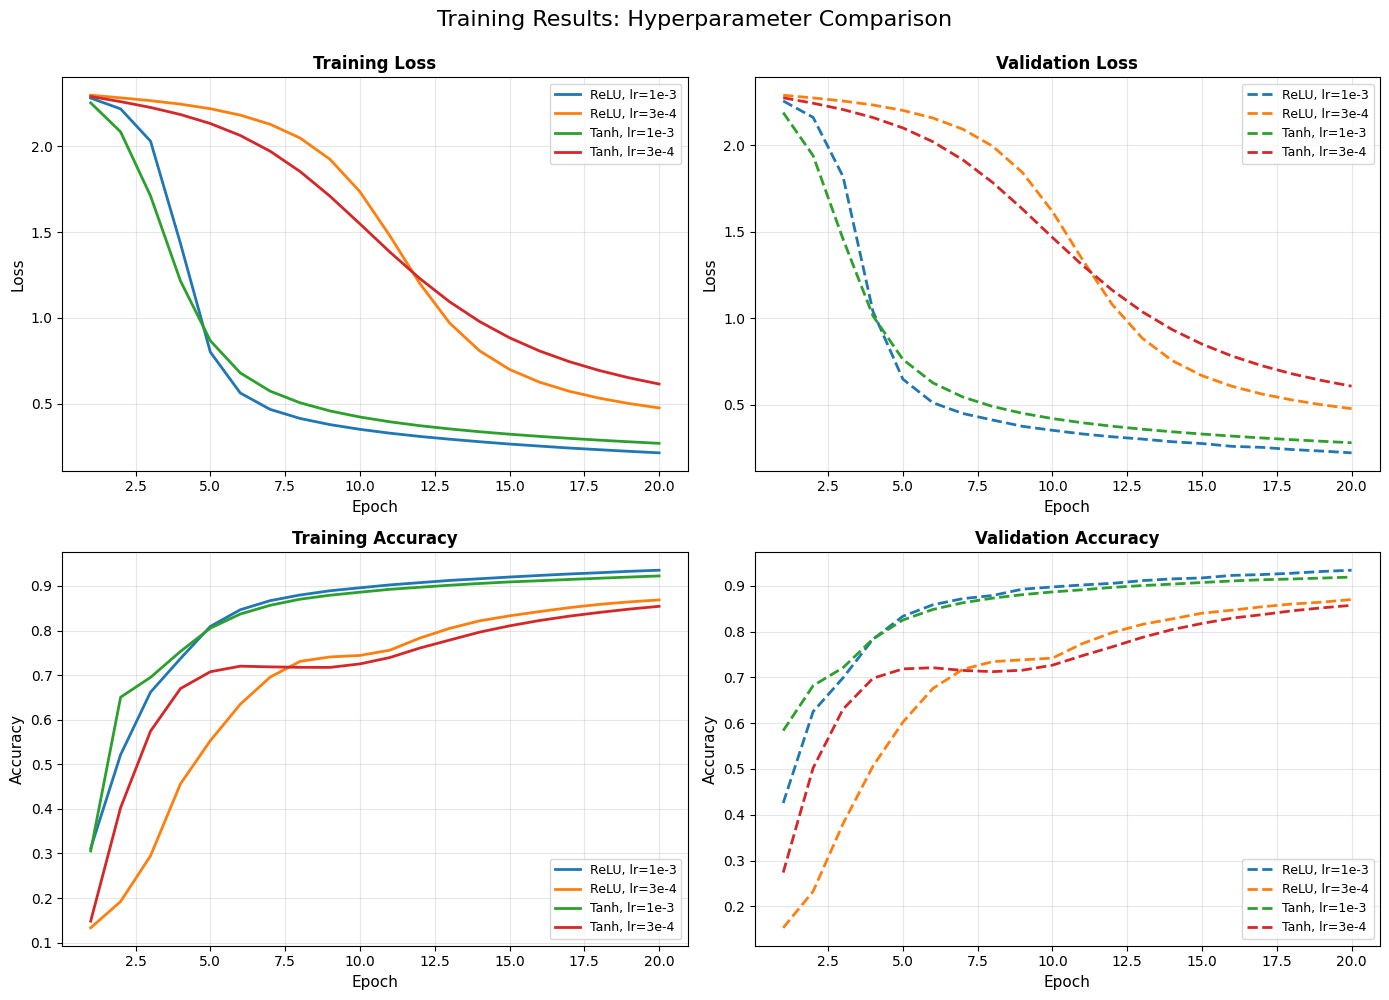

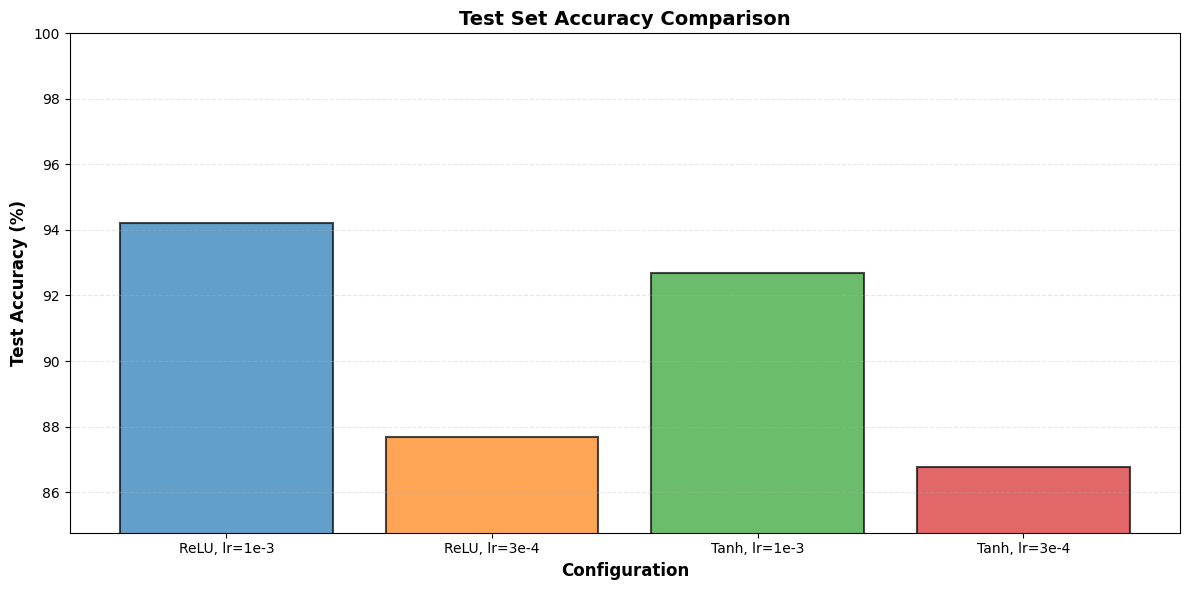

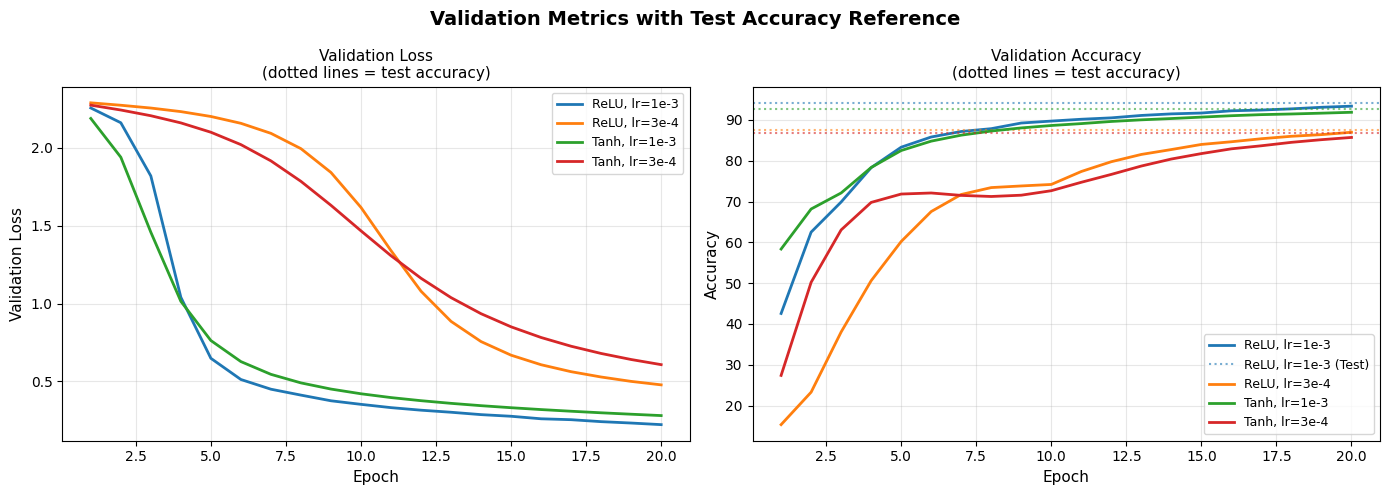

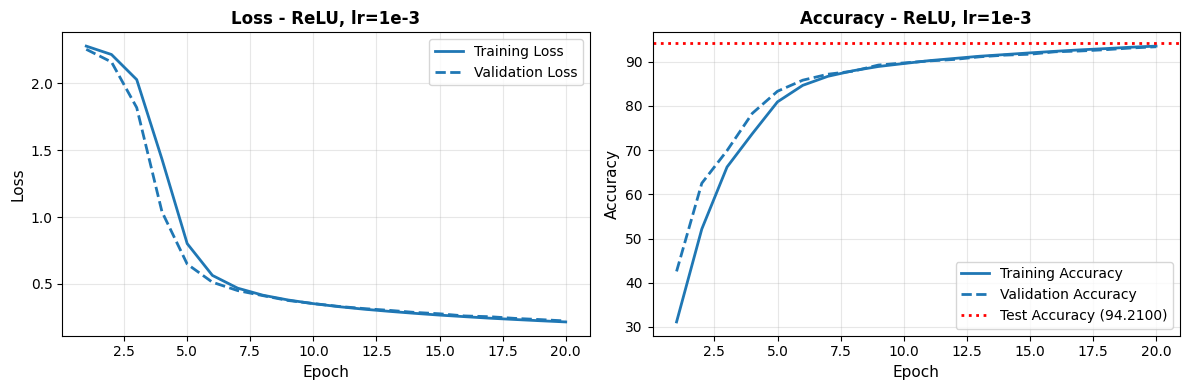

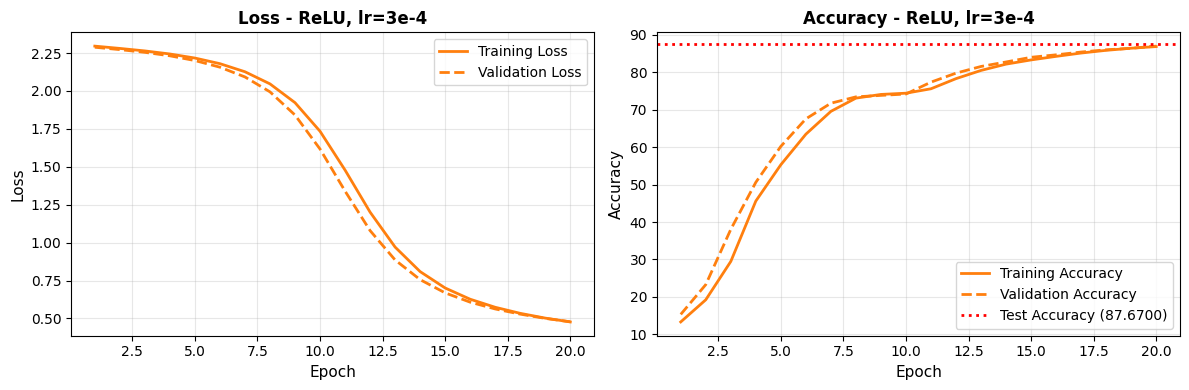

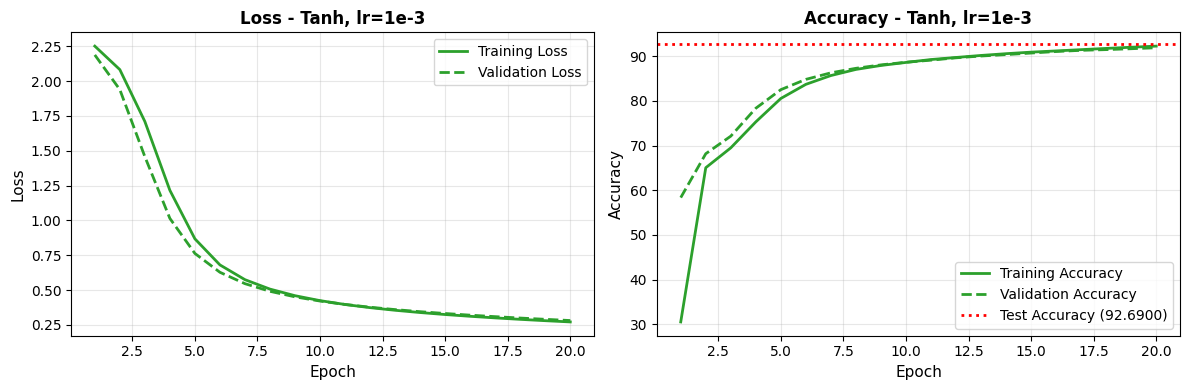

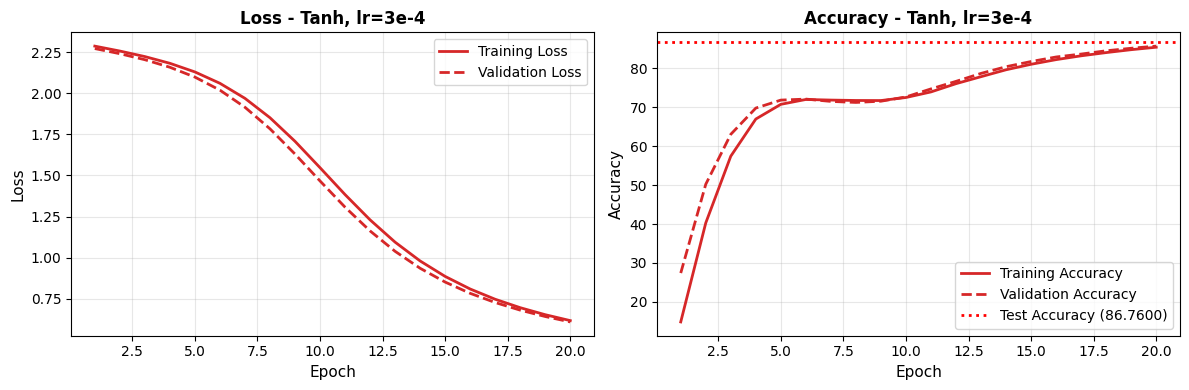


RESULTS SUMMARY

ReLU, lr=1e-3:
  Final Train Loss:     0.2154
  Final Val Loss:       0.2227
  Final Train Acc:      0.9354
  Final Val Acc:        0.9339
  Test Accuracy:        94.2100
  Train-Val Gap:        0.0015 
  Val-Test Gap:         93.2761

ReLU, lr=3e-4:
  Final Train Loss:     0.4769
  Final Val Loss:       0.4780
  Final Train Acc:      0.8687
  Final Val Acc:        0.8699
  Test Accuracy:        87.6700
  Train-Val Gap:        -0.0012 
  Val-Test Gap:         86.8001

Tanh, lr=1e-3:
  Final Train Loss:     0.2708
  Final Val Loss:       0.2808
  Final Train Acc:      0.9226
  Final Val Acc:        0.9189
  Test Accuracy:        92.6900
  Train-Val Gap:        0.0036 
  Val-Test Gap:         91.7711

Tanh, lr=3e-4:
  Final Train Loss:     0.6157
  Final Val Loss:       0.6077
  Final Train Acc:      0.8544
  Final Val Acc:        0.8572
  Test Accuracy:        86.7600
  Train-Val Gap:        -0.0028 
  Val-Test Gap:         85.9028


Best Configuration:
  ReLU, lr=1e-3

In [52]:
# Plots
"WRITE YOUR CODE HERE"
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.ticker as mtick


config_names = [
    "ReLU, lr=1e-3",
    "ReLU, lr=3e-4", 
    "Tanh, lr=1e-3",
    "Tanh, lr=3e-4"
]

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Training Results: Hyperparameter Comparison', fontsize=16, y=0.995)

# Plot each configuration
for idx, (result, name, color) in enumerate(zip(value_array, config_names, colors)):
    epochs = list(range(1, len(result['train_loss']) + 1))
    
    axes[0, 0].plot(epochs, result['train_loss'], 
                    label=name, color=color, linewidth=2)
    
    axes[0, 1].plot(epochs, result['val_loss'],
                    label=name, color=color, linewidth=2, linestyle='--')
    
    axes[1, 0].plot(epochs, result['train_acc'],
                    label=name, color=color, linewidth=2)
    
    axes[1, 1].plot(epochs, result['val_acc'],
                    label=name, color=color, linewidth=2, linestyle='--')

axes[0, 0].set_xlabel('Epoch', fontsize=11)
axes[0, 0].set_ylabel('Loss', fontsize=11)
axes[0, 0].set_title('Training Loss', fontsize=12, fontweight='bold')
axes[0, 0].legend(fontsize=9)
axes[0, 0].grid(True, alpha=0.3)

axes[0, 1].set_xlabel('Epoch', fontsize=11)
axes[0, 1].set_ylabel('Loss', fontsize=11)
axes[0, 1].set_title('Validation Loss', fontsize=12, fontweight='bold')
axes[0, 1].legend(fontsize=9)
axes[0, 1].grid(True, alpha=0.3)

axes[1, 0].set_xlabel('Epoch', fontsize=11)
axes[1, 0].set_ylabel('Accuracy', fontsize=11)
axes[1, 0].set_title('Training Accuracy', fontsize=12, fontweight='bold')
axes[1, 0].legend(fontsize=9)
axes[1, 0].grid(True, alpha=0.3)

axes[1, 1].set_xlabel('Epoch', fontsize=11)
axes[1, 1].set_ylabel('Accuracy', fontsize=11)
axes[1, 1].set_title('Validation Accuracy', fontsize=12, fontweight='bold')
axes[1, 1].legend(fontsize=9)
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('training_results.png', dpi=300, bbox_inches='tight')
plt.show()

# ============================================
# Separate figure for Test Accuracy Comparison
# ============================================

test_accs = [result['test_acc'] for result in value_array]

# Clamp to [0, 100] just in case
test_accs = [min(100.0, max(0.0, acc)) for acc in test_accs]

# Calculate min/max for axis
min_acc = min(test_accs)
max_acc = max(test_accs)
y_range = max_acc - min_acc

# Set y-axis limits
if y_range < 10:
    y_min = max(0, min_acc - 2)
else:
    y_min = max(0, min_acc - 5)

y_max = 100.0  # Always cap at 100%

fig2, ax2 = plt.subplots(figsize=(12, 6))
x_pos = np.arange(len(config_names))
bars = ax2.bar(x_pos, test_accs, color=colors, alpha=0.7, edgecolor='black', linewidth=1.5)

# Unflipped y-axis (normal)
ax2.set_ylim(y_min, y_max)

# Labels and titles
ax2.set_xlabel('Configuration', fontsize=12, fontweight='bold')
ax2.set_ylabel('Test Accuracy (%)', fontsize=12, fontweight='bold')
ax2.set_title('Test Set Accuracy Comparison', fontsize=14, fontweight='bold')
ax2.set_xticks(x_pos)
ax2.set_xticklabels(config_names, rotation=0, ha='center')

# Optional: round y-axis ticks
ax2.yaxis.set_major_locator(plt.MaxNLocator(integer=True))

ax2.grid(True, alpha=0.3, axis='y', linestyle='--')

plt.tight_layout()
plt.savefig('test_accuracy_comparison_unflipped.png', dpi=300, bbox_inches='tight')
plt.show()

# ============================================
# Combined plot with test accuracy as horizontal lines
# ============================================
fig3, axes3 = plt.subplots(1, 2, figsize=(14, 5))
fig3.suptitle('Validation Metrics with Test Accuracy Reference', fontsize=14, fontweight='bold')

for idx, (result, name, color) in enumerate(zip(value_array, config_names, colors)):
    epochs = list(range(1, len(result['val_loss']) + 1))
    
    # Validation Loss with Test Accuracy line
    axes3[0].plot(epochs, result['val_loss'],
                  label=f"{name}", color=color, linewidth=2)
    # axes3[0].axhline(y=result['test_acc'], color=color, 
    #                  linestyle=':', linewidth=1.5, alpha=0.6)
    
    # Validation Accuracy with Test Accuracy line
    axes3[1].plot(epochs, np.array(result['val_acc'])*100,
                  label=f"{name}", color=color, linewidth=2)
    axes3[1].axhline(y=result['test_acc'], color=color, 
                     linestyle=':', linewidth=1.5, alpha=0.6,
                     label=f"{name} (Test)" if idx == 0 else "")

axes3[0].set_xlabel('Epoch', fontsize=11)
axes3[0].set_ylabel('Validation Loss', fontsize=11)
axes3[0].set_title('Validation Loss\n(dotted lines = test accuracy)', fontsize=11)
axes3[0].legend(fontsize=9)
axes3[0].grid(True, alpha=0.3)

axes3[1].set_xlabel('Epoch', fontsize=11)
axes3[1].set_ylabel('Accuracy', fontsize=11)
axes3[1].set_title('Validation Accuracy\n(dotted lines = test accuracy)', fontsize=11)
axes3[1].legend(fontsize=9)
axes3[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('validation_with_test.png', dpi=300, bbox_inches='tight')
plt.show()

# ============================================
# Individual plots for each configuration (for detailed analysis)
# ============================================
for idx, (result, name, color) in enumerate(zip(value_array, config_names, colors)):
    fig4, axes4 = plt.subplots(1, 2, figsize=(12, 4))
    epochs = list(range(1, len(result['train_loss']) + 1))
    
    # Loss plot
    axes4[0].plot(epochs, result['train_loss'], label='Training Loss', 
                  color=color, linewidth=2)
    axes4[0].plot(epochs, result['val_loss'], label='Validation Loss', 
                  color=color, linewidth=2, linestyle='--')
    axes4[0].set_xlabel('Epoch', fontsize=11)
    axes4[0].set_ylabel('Loss', fontsize=11)
    axes4[0].set_title(f'Loss - {name}', fontsize=12, fontweight='bold')
    axes4[0].legend()
    axes4[0].grid(True, alpha=0.3)
    
    # Accuracy plot
    axes4[1].plot(epochs, np.array(result['train_acc']) *100, label='Training Accuracy', 
                  color=color, linewidth=2)
    axes4[1].plot(epochs, np.array(result['val_acc']) *100, label='Validation Accuracy', 
                  color=color, linewidth=2, linestyle='--')
    axes4[1].axhline(y=result['test_acc'], color='red', linestyle=':', 
                     linewidth=2, label=f'Test Accuracy ({result["test_acc"]:.4f})')
    axes4[1].set_xlabel('Epoch', fontsize=11)
    axes4[1].set_ylabel('Accuracy', fontsize=11)
    axes4[1].set_title(f'Accuracy - {name}', fontsize=12, fontweight='bold')
    axes4[1].legend()
    axes4[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(f'config_{idx+1}_{name.replace(",", "").replace(" ", "_")}.png', 
                dpi=300, bbox_inches='tight')
    plt.show()

# ============================================
# Print summary statistics for discussion
# ============================================
print("\n" + "="*70)
print("RESULTS SUMMARY")
print("="*70)

for name, result in zip(config_names, value_array):
    print(f"\n{name}:")
    print(f"  Final Train Loss:     {result['train_loss'][-1]:.4f}")
    print(f"  Final Val Loss:       {result['val_loss'][-1]:.4f}")
    print(f"  Final Train Acc:      {result['train_acc'][-1]:.4f}")
    print(f"  Final Val Acc:        {result['val_acc'][-1]:.4f}")
    print(f"  Test Accuracy:        {result['test_acc']:.4f}")
    
    # Check for overfitting
    overfit = result['train_acc'][-1] - result['val_acc'][-1]
    print(f"  Train-Val Gap:        {overfit:.4f} {'(overfitting detected)' if overfit > 0.1 else ''}")
    
    # Generalization (val vs test)
    generalization = abs(result['val_acc'][-1] - result['test_acc'])
    print(f"  Val-Test Gap:         {generalization:.4f}")

print("\n" + "="*70)
print("\nBest Configuration:")
best_idx = np.argmax([result['test_acc'] for result in value_array])
print(f"  {config_names[best_idx]} with Test Accuracy: {value_array[best_idx]['test_acc']:.4f}")
print("="*70)

  
2. **Write a short discussion:** (~1 page) reflecting on:
   - Which **activations/learning rates** choices performed best and why?
   - Any signs of over/underfitting you observed.

Note: Please upload the discussion write-ups of all sections of **Part 3** as a single PDF file on Gradescope.

In [ ]:
# ok